In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

def set_background(color):    
    script = (
        "var cell = this.closest('.jp-CodeCell');"
        "var editor = cell.querySelector('.jp-Editor');"
        "editor.style.background='{}';"
        "this.parentNode.removeChild(this)"
    ).format(color)
    
    display(HTML('<img src onerror="{}" style="display:none">'.format(script)))

In [2]:
set_background("green")
from ipynb.fs.full.kernels import *

/Users/alexastewart/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [194]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
	
	
def getPairwiseSeparations( ri, rj ):
	"""
	Get pairwise desprations between 2 sets of coordinates
	ri    is an M x 3 matrix of positions
	rj    is an N x 3 matrix of positions
	dx, dy, dz   are M x N matrices of separations
	"""
	
	M = ri.shape[0]
	N = rj.shape[0]
	
	# positions ri = (x,y,z)
	rix = ri[:,0].reshape((M,1))
	riy = ri[:,1].reshape((M,1))
	riz = ri[:,2].reshape((M,1))
	
	# other set of points positions rj = (x,y,z)
	rjx = rj[:,0].reshape((N,1))
	rjy = rj[:,1].reshape((N,1))
	rjz = rj[:,2].reshape((N,1))
	
	# matrices that store all pairwise particle separations: r_i - r_j
	dx = rix - rjx.T
	dy = riy - rjy.T
	dz = riz - rjz.T
	
	return dx, dy, dz
	

def getDensity( r, pos, m, h ):
	"""
	Get Density at sampling loctions from SPH particle distribution
	r     is an M x 3 matrix of sampling locations
	pos   is an N x 3 matrix of SPH particle positions
	m     is the particle mass
	h     is the smoothing length
	rho   is M x 1 vector of densities
	"""
	
	M = r.shape[0]
	
	dx, dy, dz = getPairwiseSeparations( r, pos );
	
	rho = np.sum( m * W(dx, dy, dz, h), 1 ).reshape((M,1))
	
	return rho
	
	
def getPressure(rho, k, n):
	"""
	Equation of State
	rho   vector of densities
	k     equation of state constant
	n     polytropic index
	P     pressure
	"""
	
	P = k * rho**(1+1/n)
	return P
	

def getAcc( pos, vel, m, h, k, n, lmbda, nu ):
	"""
	Calculate the acceleration on each SPH particle
	pos   is an N x 3 matrix of positions
	vel   is an N x 3 matrix of velocities
	m     is the particle mass
	h     is the smoothing length
	k     equation of state constant
	n     polytropic index
	lmbda external force constant
	nu    viscosity
	a     is N x 3 matrix of accelerations
	"""
	
	N = pos.shape[0]
	
	# Calculate densities at the position of the particles
	rho = getDensity( pos, pos, m, h )
	
	# Get the pressures
	P = getPressure(rho, k, n)
	
	# Get pairwise distances and gradients
	dx, dy, dz = getPairwiseSeparations( pos, pos )
	dWx, dWy, dWz = gradW( dx, dy, dz, h )
	
	# Add Pressure contribution to accelerations
	ax = - np.sum( m * ( P/rho**2 + P.T/rho.T**2  ) * dWx, 1).reshape((N,1))
	ay = - np.sum( m * ( P/rho**2 + P.T/rho.T**2  ) * dWy, 1).reshape((N,1))
	az = - np.sum( m * ( P/rho**2 + P.T/rho.T**2  ) * dWz, 1).reshape((N,1))
	
	# pack together the acceleration components
	a = np.hstack((ax,ay,az))
	#print("a",a[0])
	# Add external potential force
	a -= lmbda * pos
	#print("lmbda",a[0])
	# Add viscosity
	a -= nu * vel
	#print("vel",a[0])
	
	return a
	

In [195]:
def getPairwiseSeparations(ri, rj):
    """ Just finds Cartesian Pairwise Separations between 2 points. 
    ri is an M x 3 matrix of positions, 
    rj    is an N x 3 matrix of positions 
    returns dx, dy, dz   are M x N matrices of separations. """
    M = ri.shape[0]
    N = rj.shape[0]
    rix = ri[:,0].reshape((M,1)) # positions ri = (x,y,z)
    riy = ri[:,1].reshape((M,1))
    riz = ri[:,2].reshape((M,1))
    rjx = rj[:,0].reshape((N,1)) # other set of points positions rj = (x,y,z)
    rjy = rj[:,1].reshape((N,1))
    rjz = rj[:,2].reshape((N,1))
    return rix - rjx.T , riy - rjy.T, riz - rjz.T # (dx, dy, dz) # return matrices that store all pairwise particle separations: r_i - r_j

def getDensity(r, pos, m, h , tag="gaussian"):
    """ Reconstruct the density at any location based on the sph points.
            r     is an M x 3 matrix of sampling locations
            pos   is an N x 3 matrix of SPH particle positions
          
          dx, dy, dz are all M x N matrices. (Seperations). 
          - Sum over all particle interactions with the points to get the density at the locations in r.
          
          m = particle mass, h = smoothing length """
    M = r.shape[0]
    dx, dy, dz = getPairwiseSeparations( r, pos );
    w = W(dx, dy, dz, h,tag=tag)
    rho = np.sum( m * w, 1 ).reshape((M,1)) # (56)
    return rho

In [196]:
def getAcc( pos, vel, m, h, k, n, lmbda, nu,tag="gaussian" ):
	"""
	Calculate the acceleration on each SPH particle
	pos   is an N x 3 matrix of positions
	vel   is an N x 3 matrix of velocities
	m     is the particle mass
	h     is the smoothing length
	k     equation of state constant
	n     polytropic index
	lmbda external force constant
	nu    viscosity
	a     is N x 3 matrix of accelerations
	"""
	
	N = pos.shape[0]
	
	# Calculate densities at the position of the particles
	rho = getDensity( pos, pos, m, h ,tag=tag)
	
	# Get the pressures
	P = getPressure(rho, k, n)
	
	# Get pairwise distances and gradients
	dx, dy, dz = getPairwiseSeparations( pos, pos )
	dWx, dWy, dWz = gradW( dx, dy, dz, h ,tag=tag)
	
	# Add Pressure contribution to accelerations
	ax = - np.sum( m * ( P/rho**2 + P.T/rho.T**2  ) * dWx, 1).reshape((N,1))
	ay = - np.sum( m * ( P/rho**2 + P.T/rho.T**2  ) * dWy, 1).reshape((N,1))
	az = - np.sum( m * ( P/rho**2 + P.T/rho.T**2  ) * dWz, 1).reshape((N,1))
	
	# pack together the acceleration components
	a = np.hstack((ax,ay,az))
	#print("a",a[0])
	# Add external potential force
	a -= lmbda * pos
	#print("lmbda",a[0])
	# Add viscosity
	a -= nu * vel
	#print("vel",a[0])
	
	return a

In [197]:
def save(self, timestep, move=False,filename="single-star-Nov20"):
    # save data to output files
    loc = "data/" + filename + "/initialization/"
    if not os.path.exists(loc):
        os.makedirs(loc)
    np.savetxt(loc+'pos_'+str(timestep)+'.csv', np.asarray(self.pos))
    np.savetxt(loc+'vel_'+str(timestep)+'.csv', np.asarray(self.vel)) 
    np.savetxt(loc+'acc_'+str(timestep)+'.csv', np.asarray(self.acc)) 
    np.savetxt(loc+'rho_'+str(timestep)+'.csv', np.asarray(self.pos)) 
import os

In [231]:
class NS_:
    def __init__(self, name, mass = 1, radius = 13, num_points = 300,init_plot_filename = "file",h_init=0.5, nu=1,lagrange_tag = "vanilla",kernel_type="wendland_2",eta=0.01,clmbda=1, dt = 0.0001 ,tEnd = 0.005,test=False,plot_initialized_star=True):
        """ 
        NEUTRON STAR OBJECT ATTRIBUTES
        tag, mass, radius, m (point mass), num_points, eos, lagrange_tag, kernel_type. eta, nu
        Point attributes: position (N x 3), vel (N x 3), acc (N x 3), density (N x 1), pressure (N x 1).        
        Initializes a NS object.
        """
        self.plot_init=plot_initialized_star
        h = None
        # Simulation parameters
        R = radius
        N         = num_points    # Number of particles
        t         = 0      # current time of the simulation
        tEnd      = 5     # time at which simulation ends
        dt        = 0.05   # timestep
        M         = mass      # star mass
        if h == None:
            h = R/10 
        self.h = h
        # star radius
        # smoothing length
        k         = 100    # equation of state constant
        n         = 1      # polytropic index
        nu        = 1      # damping
        lmbda = 2*k*(1+n)*np.pi**(-3/(2*n)) * (M*gamma(5/2+n)/R**3/gamma(1+n))**(1/n) / R**2  # ~ 2.01
        self.lmbda=lmbda
        self.name = name # "Name" of the star, just a string for identification
        self.radius = radius # star radius in km ======= Star properties
        self.mass = mass # star mass in solar Masses 
        self.num_points = num_points # number of SPH points modeling the star
        self.com = [0,0,0] # center of mass is initialized at the origin. ======= Star motion
        #self.pos, self.vel, self.acc = init_xva(self.num_points, R = self.radius)
        self.pos = np.random.randn(N,3)
        self.vel   = np.zeros(self.pos.shape)
        self.m = mass/self.num_points # each point has "mass" m in solar masses (maybe change later to baryon number)
        self.acc = getAcc( self.pos, self.vel, self.m, h, k, n, lmbda, nu )
        self.num_points = np.shape(self.pos)[0] # reset the number of points to match the initialized sphere
        self.points_position = np.copy(self.pos) # true position, this will be corrected when we move the center of mass. 
        self.kernel_type = kernel_type # Kernel used for determining particle density ====== Smoothing Length and Particle Density  ==  
        self.eta = eta # Multiplies the smoothing length based on particle density
        self.rho = getDensity(self.pos, self.pos, self.m, self.h)
        #self.h = calculate_h(self) # Smoothing length depends on density of the particle.
        self.Gamma = 5/3
        self.Adot = np.zeros(self.rho.shape)
        self.A = np.zeros(self.rho.shape)
        self.c = None
        self.nu=1
        self.ltag=""
        
        #========= INITIALIZATION STEP. Initialize star from Random points =====#
        if not test:
            print("Initializing...")
        r_start = self.pos[0][0]
        self.initialize(tEnd=tEnd,tag=kernel_type) # initialize the star
        return None


    def test(self,plot=True,test=True):
        plot_init =[]
        plot_init.append(self.points_position)
        self.test = test
        self.initialization_notes = "none"
        INFO_OUT = "Single star before relaxation step at t_relax=0.\nStars are initialized on a spherical cut of a uniform grid with 0 velocity and 0 acceleration at t=0.\nn_points="+str(num_points)+"\nnum_points_extract="+str(self.num_points)+"\ngrid size: "+str(2*self.radius)+"\nstar mass: "+str(self.mass)+" solar masses"
        INFO_OUT += "\nadiabatic index: "+ str(self.Gamma) +"\npoint mass: "+str(self.m)+" solar masses"+"\nkernel type: "+str(self.kernel_type)+ "\n\nFor more info on the star initial relaxation conditions, see relax-info.txt.\nFor more info on kernel type, smoothing lengths, see the sph imports file."
        with open(tag+'_info.txt', 'w') as f:
            f.write(INFO_OUT) 
        if test:
            self.grav_test = None
            test_acc_data = {"acc": [], "dAdt": [],"visc":[],"pos":[],"rho":[],"grav":[],"Pressure":[],"(P - grav force)":[],"smoothing length":[],"Pos":[]}
        plot_init.append(self.pos)
        if test:
            if abs(self.acc[0][0]) > 1e9:
                self.initialization_notes = "diverged after"  + str(i) + " timesteps of size " + str(dt) + ". (Total time = " + str(i*dt) + ")"
            elif abs(self.acc[0][0]) < 1e-14 and abs(self.acc[0][0]) != 0:
                print(self.acc[0][0])
                self.initialization_notes = "zerod after " + str(i) + " timesteps  of size " + str(dt) + ". (Total time = " + str(i*dt) + ")"
            elif abs(self.acc[0][0]) < 1e-10 and i > 7 and abs(self.pos[0][0]) < 1e2 and abs(self.pos[0][0]) > 1e-2:
                self.initialization_notes = "Slow velocity with radius in range after initialization after t=" +  str(i*dt) + ".(" + str(i) + " timesteps  of size " + str(dt)+")."
            elif abs(self.pos[0][0]) - r_start > 0 and abs(self.pos[0][0]) - r_start < 1e-2:
                self.initialization_notes = "extremely small acceleration values barely touch points after t=" +  str(i*dt) + ".(" + str(i) + " timesteps  of size " + str(dt)+")."
            else:
                self.initialization_notes = "did not diverge or converge. Final acceleration: was "+ str(self.acc[0][0]) + "after t=" +  str(i*dt) + ".(" + str(i) + " timesteps  of size " + str(dt)+")." + "\nStaring radius: " + str(r_start)+ "\nFinal radius: " + str(self.pos[0][0])
            test_acc_data['acc'].append(self.acc[0][0])
            test_acc_data["pos"].append(self.pos[0][0])
            test_acc_data["Pos"].append(self.pos)
            test_acc_data['dAdt'].append(self.Adot[0][0])                
            test_acc_data['rho'].append(self.rho[0][0])
            test_acc_data["visc"].append(self.grav_test[1])
            test_acc_data["grav"].append(self.grav_test[0])
            test_acc_data["Pressure"].append(self.grav_test[2])
            test_acc_data["(P - grav force)"].append(self.grav_test[3])
            test_acc_data["smoothing length"].append(self.h[0][0])
            self.TEST_ACC_DATA = test_acc_data
            if plot:
                print("plotting")
                plot_init.append(self.pos)
                data = plot_init
                plot(data, "plot_test_NS" + self.kernel_type)
                print(init_plot_filename)
        return None

            #========================================================================#
                
    def save(self, timestep, move=False,filename="single-star-Nov20"):
        # save data to output files
        loc = "data/" + filename + "/initialization/"
        if not os.path.exists(loc):
            os.makedirs(loc)
        np.savetxt(loc+'pos_'+str(timestep)+'.csv', np.asarray(self.pos))
        if move:
            np.savetxt(loc+'com_'+str(timestep)+'.csv', np.asarray(self.com))
        np.savetxt(loc+'vel_'+str(timestep)+'.csv', np.asarray(self.vel)) 
        np.savetxt(loc+'acc_'+str(timestep)+'.csv', np.asarray(self.acc)) 
        np.savetxt(loc+'rho_'+str(timestep)+'.csv', np.asarray(self.pos)) 
        
    def initialize(self,tEnd = 5,plotRealTime = False,h = None,tag="gaussian",save=False,dt=None):
        """ SPH simulation """
        # Simulation parameters
        N         = self.num_points    # Number of particles
        t         = 0      # current time of the simulation
        # tEnd is the time at which simulation ends
        if dt== None:
            dt        = 0.05   # timestep
        M = self.mass
        R = self.radius
        if h == None:
            h = R/10  # smoothing length
        k         = 100    # equation of state constant
        n         = 1      # polytropic index
        nu        = 1      # damping
        lmbda = 2*k*(1+n)*np.pi**(-3/(2*n)) * (M*gamma(5/2+n)/R**3/gamma(1+n))**(1/n) / R**2  # ~ 2.01
        m     = self.m                  # single particle mass
        # calculate initial gravitational accelerations
        Nt = int(np.ceil(tEnd/dt))# number of timesteps
        if self.plot_init:
            # prep figure
            fig = plt.figure(figsize=(4,5), dpi=80)
            grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)
            ax1 = plt.subplot(grid[0:2,0])
            ax2 = plt.subplot(grid[2,0])
        rr = np.zeros((100,3))
        rlin = np.linspace(0,1,100)
        rr[:,0] =rlin
        rho_analytic = lmbda/(4*k) * (R**2 - rlin**2)
        if save:
            print("Timesteps:",Nt)
        # Simulation Main Loop
        for i in range(Nt):
            self.vel += self.acc * dt/2 # (1/2) kick
            self.pos += self.vel * dt # drift
            self.acc = getAcc( self.pos, self.vel, self.m, h, k, n, lmbda, nu )# update accelerations
            self.vel += self.acc * dt/2# (1/2) kick
            t += dt # update time
            timestep=i
            self.rho = getDensity( self.pos, self.pos, self.m, self.h ) # get density for plotting
            if save:
                loc = "init_test_data/"+ tag+"_"+str(N)+"/"
                if not os.path.exists(loc):
                    os.makedirs(loc)
                np.savetxt(loc+'pos_'+str(timestep)+'.csv', np.asarray(self.pos))
                np.savetxt(loc+'vel_'+str(timestep)+'.csv', np.asarray(self.vel)) 
                np.savetxt(loc+'acc_'+str(timestep)+'.csv', np.asarray(self.acc)) 
                np.savetxt(loc+'rho_'+str(timestep)+'.csv', np.asarray(self.rho)) 
            # plot in real time
            if plotRealTime or (i == Nt-1):# or (i%10==0):
                if ((i == Nt-1) or plotRealTime) and self.plot_init and (i%20==0):
                    print("t=",t)
                    plt.sca(ax1)
                    plt.cla()
                    cval = np.minimum((self.rho-3)/3,1).flatten()
                    plt.scatter(self.pos[:,0],self.pos[:,1], c=cval, cmap=plt.cm.autumn, s=5, alpha=0.5)
                    ax1.set(xlim=(-2*R, 2*R), ylim=(-2*R, 2*R))
                    ax1.set_aspect('equal', 'box')
                    #ax1.set_xticks([-1,0,1])
                    #ax1.set_yticks([-1,0,1])
                    ax1.set_facecolor('grey')
                    ax1.set_facecolor((.1,.1,.1))
                    plt.sca(ax2)
                    plt.cla()
                    ax2.set(xlim=(0, R), ylim=(0, 3))
                    ax2.set_aspect(0.1)
                    plt.plot(rlin, rho_analytic, color='gray', linewidth=2)
                    rho_radial = getDensity( rr, self.pos, self.m, self.h )
                    plt.plot(rlin, rho_radial, color='blue')
                    plt.pause(0.001)
        if save: 
            INFO_OUT = "\n\nSingle Star Initialization Run \nnumber of Points: "+str(N)+"\nradius: "+str(R)
            INFO_OUT += "\ntimestep: "+str(dt) + "\ntotal time:"+str(tEnd) + "\nNumber of timesteps: "+str(Nt)
            INFO_OUT +="\npoint mass: "+str(self.m)+" solar masses"+"\nkernel type: "+str(self.name)+ "\nFor more info on kernel type, smoothing lengths, see the sph imports file."
            with open(loc + 'info.txt', 'w') as f:
                f.write(INFO_OUT) 

        # add labels/legend
        if self.plot_init:
            plt.sca(ax2)
            plt.xlabel('radius')
            plt.ylabel('density')

            # Save figure
            plt.savefig('sph.png',dpi=240)
            plt.show()
        print("R = ",R, ", M=", M,", k=",k,)    
        return 0   
        
    def update_star_new(self,plotRealTime = False,h = None,tag="gaussian",save=False,dt=None,COM_POSITIONS = [],params=None):
        """ SPH simulation """
        # Simulation parameters
        tEnd = 0.8 # tEnd is the time at which simulation ends
        Nt = len(COM_POSITIONS) # number of timesteps
        dt        =  tEnd/Nt # timestep
        N         = self.num_points    # Number of particles
        t         = 0      # current time of the simulation
        M = self.mass
        R = self.radius
        if h == None:
            h = R/10  # approximate smoothing length
        if params==None:
            k         = 100    # equation of state constant
            n         = 1      # polytropic index
            nu        = 1      # damping
        else:
            k = params["k"]
            n = params["n"]
            nu = params["nu"]
        lmbda = 2*k*(1+n)*np.pi**(-3/(2*n)) * (M*gamma(5/2+n)/R**3/gamma(1+n))**(1/n) / R**2  # ~ 2.01
        m     = self.m                  # single particle mass
        # calculate initial gravitational accelerations
        
        if self.plot_init:
            # prep figure
            fig = plt.figure(figsize=(4,5), dpi=80)
            grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)
            ax1 = plt.subplot(grid[0:2,0])
            ax2 = plt.subplot(grid[2,0])
        rr = np.zeros((100,3))
        rlin = np.linspace(0,1,100)
        rr[:,0] =rlin
        rho_analytic = lmbda/(4*k) * (R**2 - rlin**2)
        if save:
            print("Timesteps:",Nt)
        # Simulation Main Loop
        for i in range(Nt):
            print(self.com)
            position = self.getPosition()
            self.com = COM_POSITIONS[i]
            self.vel += self.acc * dt/2 # (1/2) kick
            self.pos += self.vel * dt # drift
            self.acc = getAcc( position, self.vel, self.m, h, k, n, lmbda, nu )# update accelerations
            self.vel += self.acc * dt/2# (1/2) kick
            t += dt # update time
            timestep=i
            self.rho = getDensity( position, position, self.m, self.h ) # get density for plotting
            print(i)
            if save:
                loc = "init_test_data/"+ tag+"_"+str(N)+"/"
                if not os.path.exists(loc):
                    os.makedirs(loc)
                np.savetxt(loc+'pos_'+str(timestep)+'.csv', np.asarray(self.pos))
                np.savetxt(loc+'vel_'+str(timestep)+'.csv', np.asarray(self.vel)) 
                np.savetxt(loc+'acc_'+str(timestep)+'.csv', np.asarray(self.acc)) 
                np.savetxt(loc+'rho_'+str(timestep)+'.csv', np.asarray(self.rho)) 
            # plot in real time
            if plotRealTime or (i == Nt-1) or (i%100==0):
                if ((i == Nt-1) or plotRealTime) and self.plot_init:# and (i%5==0):
                    print("t=",t)
                    plt.sca(ax1)
                    plt.cla()
                    cval = np.minimum((self.rho-3)/3,1).flatten()
                    plt.scatter(self.position[:,0],self.position[:,1], c=cval, cmap=plt.cm.autumn, s=2, alpha=0.5)
                    ax1.set(xlim=(-2*R, 2*R), ylim=(-2*R, 2*R))
                    ax1.set_aspect('equal', 'box')
                    #ax1.set_xticks([-1,0,1])
                    #ax1.set_yticks([-1,0,1])
                    ax1.set_facecolor('grey')
                    plt.sca(ax2)
                    plt.cla()
                    ax2.set(xlim=(0, R), ylim=(0, 3))
                    ax2.set_aspect(0.1)
                    plt.plot(rlin, rho_analytic, color='gray', linewidth=2)
                    rho_radial = getDensity( rr, self.pos, self.m, self.h )
                    plt.plot(rlin, rho_radial, color='blue')
                    plt.pause(0.001)
        if save: 
            INFO_OUT = "\n\nSingle Star Initialization Run \nnumber of Points: "+str(N)+"\nradius: "+str(R)
            INFO_OUT += "\ntimestep: "+str(dt) + "\ntotal time:"+str(tEnd) + "\nNumber of timesteps: "+str(Nt)
            INFO_OUT +="\npoint mass: "+str(self.m)+" solar masses"+"\nkernel type: "+str(self.name)+ "\nFor more info on kernel type, smoothing lengths, see the sph imports file."
            with open(loc + 'info.txt', 'w') as f:
                f.write(INFO_OUT) 

        # add labels/legend
        if self.plot_init:
            plt.sca(ax2)
            plt.xlabel('radius')
            plt.ylabel('density')

            # Save figure
            plt.savefig('sph.png',dpi=240)
            plt.show()
        print("R = ",R, ", M=", M,", k=",k,)    
        return 0        

    def update_star(self,dt=None):
        if dt == None:
            dt = calculate_tstep(self)
        self.A = self.A + dt/2*self.Adot # update A
        self.h = calculate_h(self)
        self.pos += self.vel * dt/2 # particle motion
        self.vel += self.acc * dt/2 # (1/2) kick # adds acceleration
        self.acc = getAcc(self, test=self.test) # get new Nx3 matrix of accelerations based on new pos,v
        self.vel += self.acc * dt/2 # (1/2) kick 
        self.pos += self.vel * dt/2 # particle motion
        positions = self.getPosition()
        self.rho = getDensity(positions, positions, self.m, self.h) # get updated density for each point based on m, h. 
        self.position = positions
        return self.pos
        
    def combine(self, star): 
        star1_pos = self.getPosition()
        star2_pos = star.getPosition()
        self.vel = np.concatenate((self.vel,star.vel), axis = 0)
        self.pos = np.concatenate((self.pos,star.pos), axis = 0)
        self.position = np.concatenate((star1_pos,star2_pos), axis = 0)
        self.acc = np.concatenate((self.acc,star.acc), axis = 0)
        self.rho = getDensity(self.position, self.position, self.m, self.h)
        #self.h = np.concatenate((self.h,star.h), axis = 0)
        self.num_points = self.num_points + star.num_points
        if self.m != star.m: 
            raise SyntaxError("star.m must be the same!")
        self.com = [self.com, star.com]
        return self
    
    def getPosition(self):
        """ 
        Returns the true positions of all the points 
        in the star, which are corrcted for the center of mass location.
        """
        position = np.copy(self.pos)
        COM = self.com
        # print("CENT", COM)
        if np.size(COM[0]) > 2:
            i = int(self.num_points/2)
            position[:i,0] += COM[0][0]
            position[:i,1] += COM[0][1]
            position[:i,2] += COM[0][2]
            position[i+1:,0] += COM[1][0]
            position[i+1:,1] += COM[1][1]
            position[i+1:,2] += COM[1][2]
        else:
            position[:,0] += COM[0]
            position[:,1] += COM[1]
            position[:,2] += COM[2]
        self.position  = position # track the true particle locations
        return position
    
    def move_com(self, com_new,com2 = [None]): 
        """
        Takes in new coordinates of the center of mass of the star in km. 
        Changes the location of the star's center of mass.
        """
        if com2[0] == None:
            self.com = com_new
        else:
            self.com = [com_new,com2]

    def __str__(self):
        return "\nSTAR OBJECT. Name: '" + self.name + "', Mass: " + str(self.mass) + " SMs, Radius: " # + str(self.radius) + " km" 
    def get_relative_position(self):
        """  This function returns an N x 3 array of the star's points positions relative to the center of mass """
        return self.pos
    def get_velocity(self):
        """ This function returns the star's velocity.    """
        return self.vel
    def get_mass(self):
        """ This function returns the star's overall mass . """
        return self.mass

In [232]:
star1 = NS_("mystar", mass = 1, radius = 13, num_points = 400,plot_initialized_star=False)
star2 = NS_("mysecondstar", mass = 1, radius = 13, num_points = 400,plot_initialized_star=False)
star2.com = [8,0,0]
star1.com = [-8,0,0]
combined_star = star1.combine(star2)
print(combined_star.num_points)
tEnd = 800
kt= star1.kernel_type
print(kt)

Initializing...
R =  13 , M= 1 , k= 100
Initializing...
R =  13 , M= 1 , k= 100
800
wendland_2


In [233]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def dbydt(t,v):
    x,y,vx,vy=v
    rsq=x**2+y**2
    G=1
    b=3
    beta=3
    return vx,vy,-G*x/rsq**((b+1)/2),-G*y/rsq**((beta+1)/2)

def get_COM(starting_coordinate,starting_velocity,R,plot=False):
    v = starting_coordinate[:-1] + starting_velocity[:-1]
    t_final = 25
    result=solve_ivp(dbydt,[0,t_final],v,t_eval=np.linspace(0,t_final,512))
    if plot:
        plt.scatter(result.y[0]*R,result.y[1]*R)
        plt.scatter(0,0,color='yellow',s=200)
        plt.show()
    return result.y[0]*R,result.y[1]*R

def get_com_lists(R=45):
    R = R/2
    com_list1 = get_COM([1,0,0],[0,-1,0],R)
    com_list2 = get_COM([-1,0,0],[0,1,0],R)
    out = []
    for i in range(len(com_list1[0])):
        com_list_1 = [com_list1[0][i] ,com_list1[1][i],0]
        com_list_2 = [com_list2[0][i] ,com_list2[1][i],0]
        out.append([com_list_1,com_list_2])
    return out 

[[-8, 0, 0], [8, 0, 0]]
0
t= 0.005128205128205128


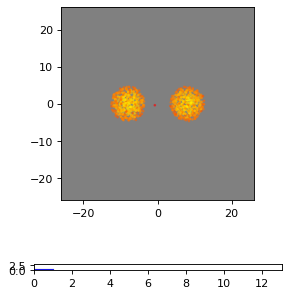

[[5.0, 0.0, 0], [-5.0, 0.0, 0]]
1
t= 0.010256410256410256


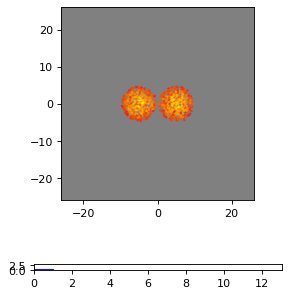

[[4.994017379146227, -0.24452083921250722, 0], [-4.994017379146227, 0.24452083921250722, 0]]
2
t= 0.015384615384615385


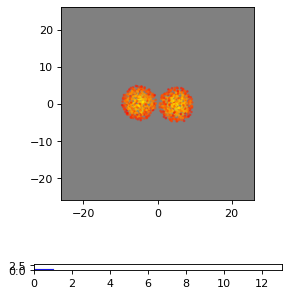

[[4.976083816878286, -0.4884564964537682, 0], [-4.976083816878286, 0.4884564964537682, 0]]
3
t= 0.020512820512820513


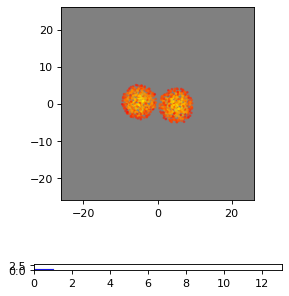

[[4.946243905713816, -0.7312342609183113, 0], [-4.946243905713816, 0.7312342609183113, 0]]
4
t= 0.02564102564102564


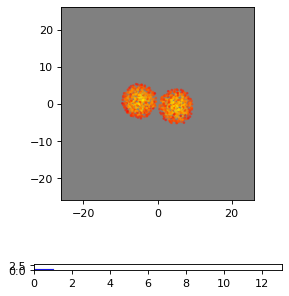

[[4.9045713525054015, -0.9722860269608302, 0], [-4.9045713525054015, 0.9722860269608302, 0]]
5
t= 0.030769230769230767


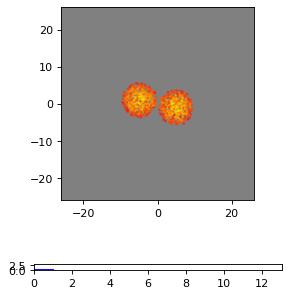

[[4.85116209693026, -1.2110120426888205, 0], [-4.85116209693026, 1.2110120426888205, 0]]
6
t= 0.035897435897435895


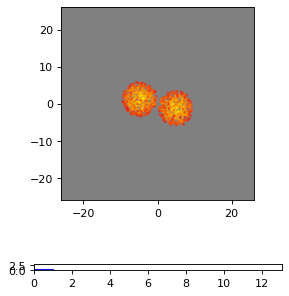

[[4.786139898154114, -1.446825360554648, 0], [-4.786139898154114, 1.446825360554648, 0]]
7
t= 0.041025641025641026


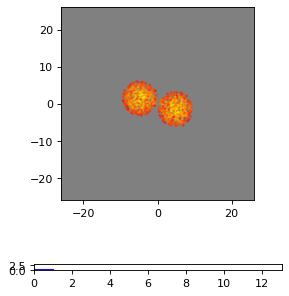

[[4.709656596361752, -1.6791537208740757, 0], [-4.709656596361752, 1.6791537208740757, 0]]
8
t= 0.046153846153846156


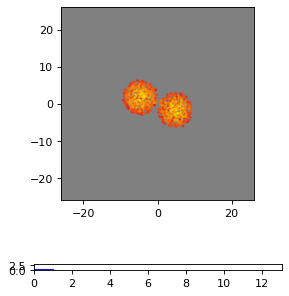

[[4.621892112757019, -1.9074395518262632, 0], [-4.621892112757019, 1.9074395518262632, 0]]
9
t= 0.05128205128205129


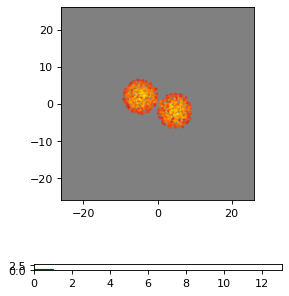

[[4.523054449562825, -2.131139969453767, 0], [-4.523054449562825, 2.131139969453767, 0]]
10
t= 0.05641025641025642


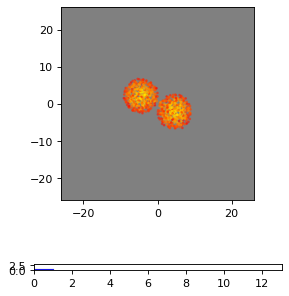

[[4.413379690021144, -2.3497267776625397, 0], [-4.413379690021144, 2.3497267776625397, 0]]
11
t= 0.06153846153846155


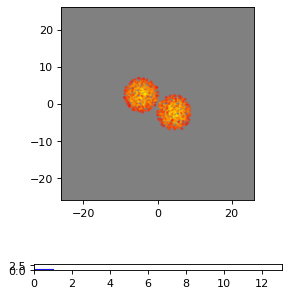

[[4.293131998393007, -2.562686468221931, 0], [-4.293131998393007, 2.562686468221931, 0]]
12
t= 0.06666666666666668


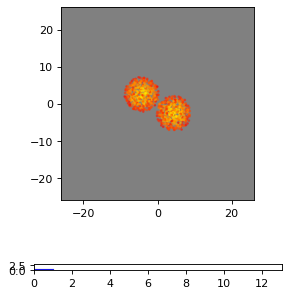

[[4.162603619958511, -2.7695202207646856, 0], [-4.162603619958511, 2.7695202207646856, 0]]
13
t= 0.0717948717948718


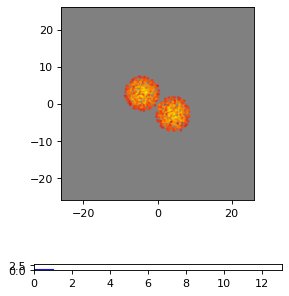

[[4.0221148810168135, -2.969743902786948, 0], [-4.0221148810168135, 2.969743902786948, 0]]
14
t= 0.07692307692307693


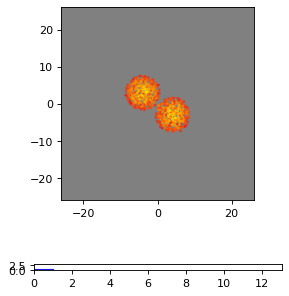

[[3.8719731791892213, -3.1629366578892366, 0], [-3.8719731791892213, 3.1629366578892366, 0]]
15
t= 0.08205128205128205


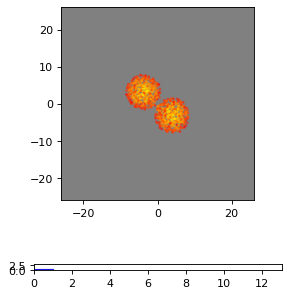

[[3.712496647827738, -3.348685648067638, 0], [-3.712496647827738, 3.348685648067638, 0]]
16
t= 0.08717948717948718


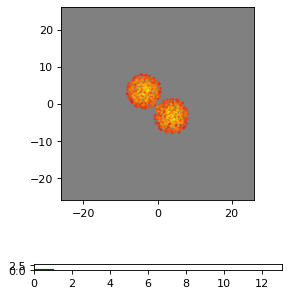

[[3.5441062991637184, -3.5264798576428955, 0], [-3.5441062991637184, 3.5264798576428955, 0]]
17
t= 0.0923076923076923


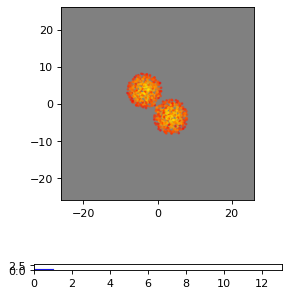

[[3.367235354989556, -3.695836846645319, 0], [-3.367235354989556, 3.695836846645319, 0]]
18
t= 0.09743589743589742


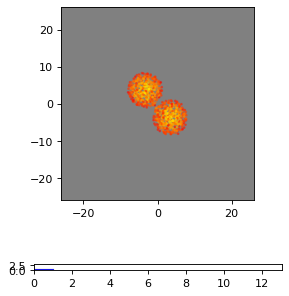

[[3.182327452659729, -3.8563050875396283, 0], [-3.182327452659729, 3.8563050875396283, 0]]
19
t= 0.10256410256410255


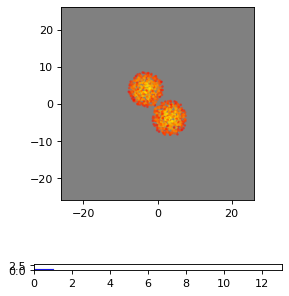

[[2.9898366450908007, -4.007463965224951, 0], [-2.9898366450908007, 4.007463965224951, 0]]
20
t= 0.10769230769230767


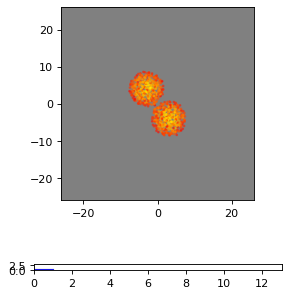

[[2.790227400761421, -4.148923777034824, 0], [-2.790227400761421, 4.148923777034824, 0]]
21
t= 0.1128205128205128


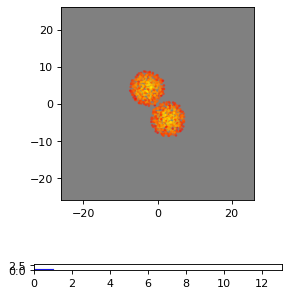

[[2.583974603712323, -4.280325732737196, 0], [-2.583974603712323, 4.280325732737196, 0]]
22
t= 0.11794871794871792


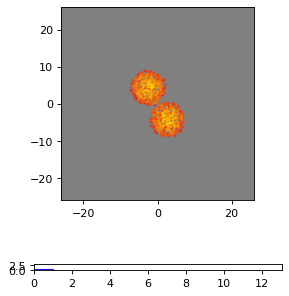

[[2.371563553546324, -4.401341954534423, 0], [-2.371563553546324, 4.401341954534423, 0]]
23
t= 0.12307692307692304


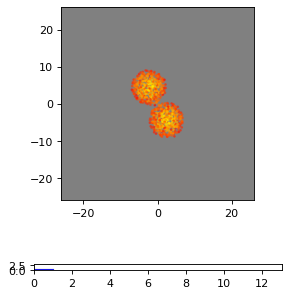

[[2.153489965428331, -4.511675477063269, 0], [-2.153489965428331, 4.511675477063269, 0]]
24
t= 0.12820512820512817


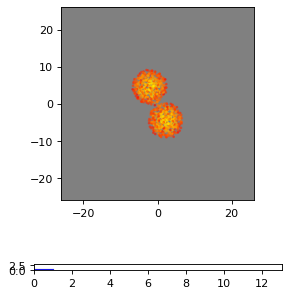

[[1.9302599700853318, -4.611060247394912, 0], [-1.9302599700853318, 4.611060247394912, 0]]
25
t= 0.1333333333333333


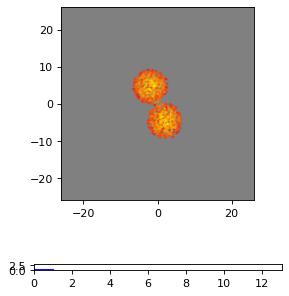

[[1.7023901138064015, -4.699261125034933, 0], [-1.7023901138064015, 4.699261125034933, 0]]
26
t= 0.13846153846153844


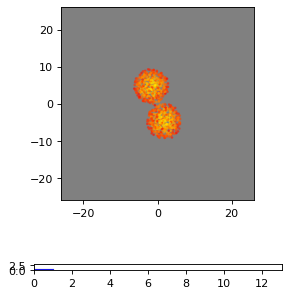

[[1.4704073584426998, -4.776073881923328, 0], [-1.4704073584426998, 4.776073881923328, 0]]
27
t= 0.14358974358974358


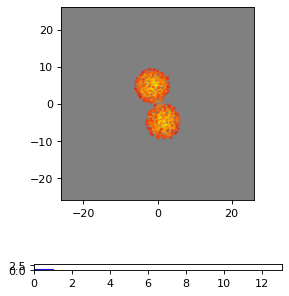

[[1.2348490814074693, -4.841325202434501, 0], [-1.2348490814074693, 4.841325202434501, 0]]
28
t= 0.14871794871794872


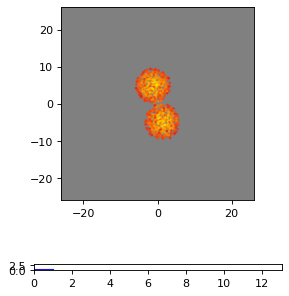

[[0.9962630756760421, -4.894872683377262, 0], [-0.9962630756760421, 4.894872683377262, 0]]
29
t= 0.15384615384615385


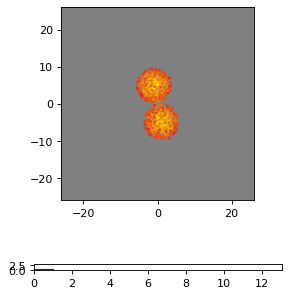

[[0.7552075497858352, -4.936604833994833, 0], [-0.7552075497858352, 4.936604833994833, 0]]
30
t= 0.158974358974359


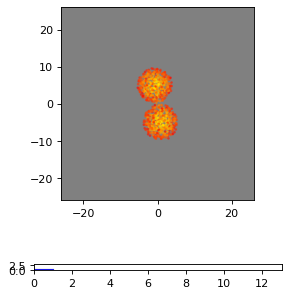

[[0.5122511084181399, -4.966441080898313, 0], [-0.5122511084181399, 4.966441080898313, 0]]
31
t= 0.16410256410256413


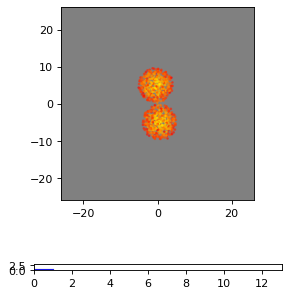

[[0.26786578012597284, -4.984355638315287, 0], [-0.26786578012597284, 4.984355638315287, 0]]
32
t= 0.16923076923076927


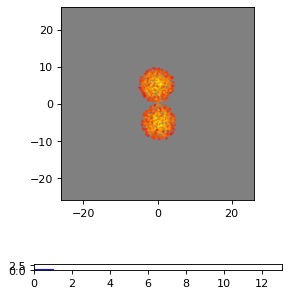

[[0.022618665352055825, -4.990315870757758, 0], [-0.022618665352055825, 4.990315870757758, 0]]
33
t= 0.1743589743589744


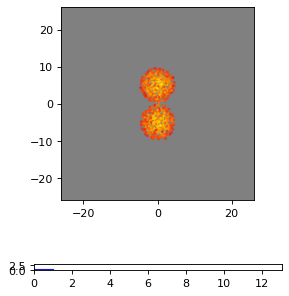

[[-0.22279315403780003, -4.984277419359601, 0], [0.22279315403780003, 4.984277419359601, 0]]
34
t= 0.17948717948717954


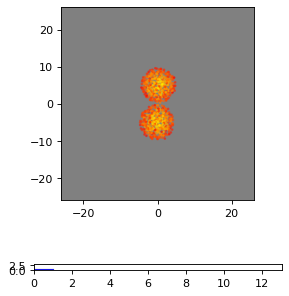

[[-0.46768947677568684, -4.9662238557568115, 0], [0.46768947677568684, 4.9662238557568115, 0]]
35
t= 0.18461538461538468


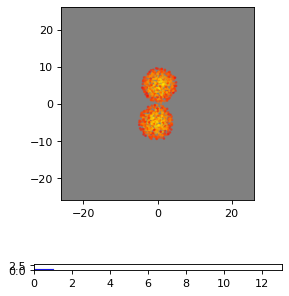

[[-0.711406982191602, -4.936166682087512, 0], [0.711406982191602, 4.936166682087512, 0]]
36
t= 0.18974358974358982


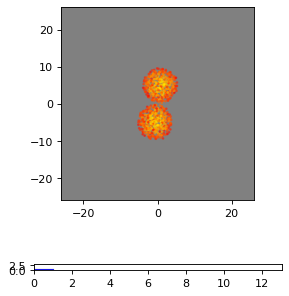

[[-0.9532992302134422, -4.894145330991945, 0], [0.9532992302134422, 4.894145330991945, 0]]
37
t= 0.19487179487179496


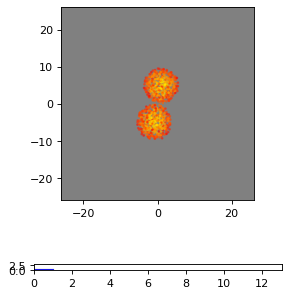

[[-1.1927366613670107, -4.84022716561248, 0], [1.1927366613670107, 4.84022716561248, 0]]
38
t= 0.2000000000000001


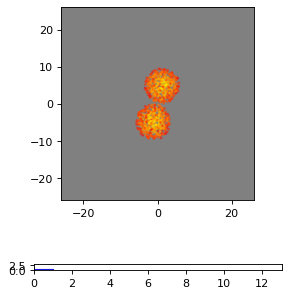

[[-1.429106596776015, -4.774507479593607, 0], [1.429106596776015, 4.774507479593607, 0]]
39
t= 0.20512820512820523


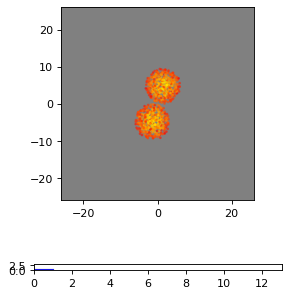

[[-1.6618132381620623, -4.697109497081945, 0], [1.6618132381620623, 4.697109497081945, 0]]
40
t= 0.21025641025641037


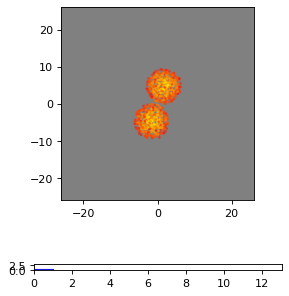

[[-1.8902776678446662, -4.60818437272623, 0], [1.8902776678446662, 4.60818437272623, 0]]
41
t= 0.2153846153846155


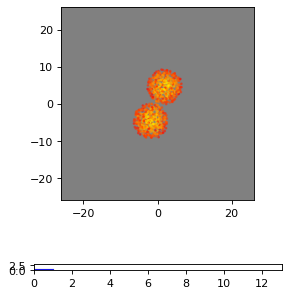

[[-2.1139378487412417, -4.507911191677325, 0], [2.1139378487412417, 4.507911191677325, 0]]
42
t= 0.22051282051282065


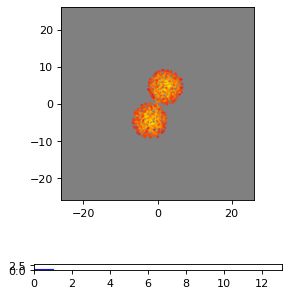

[[-2.332248624367111, -4.396496969588217, 0], [2.332248624367111, 4.396496969588217, 0]]
43
t= 0.22564102564102578


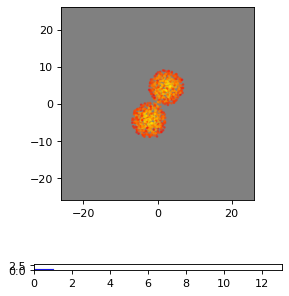

[[-2.544681718835495, -4.274176652614016, 0], [2.544681718835495, 4.274176652614016, 0]]
44
t= 0.23076923076923092


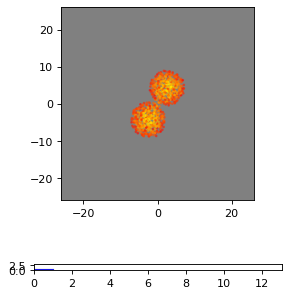

[[-2.7507257368575218, -4.141213117411953, 0], [2.7507257368575218, 4.141213117411953, 0]]
45
t= 0.23589743589743606


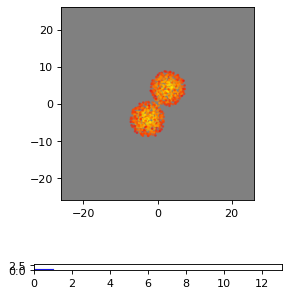

[[-2.949886163742219, -3.9978971711413873, 0], [2.949886163742219, 3.9978971711413873, 0]]
46
t= 0.2410256410256412


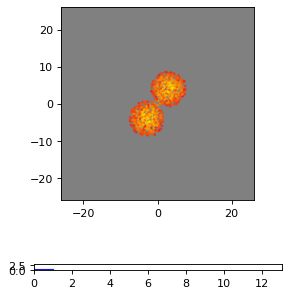

[[-3.141685365396521, -3.8445475514638003, 0], [3.141685365396521, 3.8445475514638003, 0]]
47
t= 0.24615384615384633


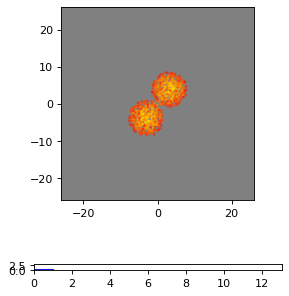

[[-3.3256625883252626, -3.6815109265427948, 0], [3.3256625883252626, 3.6815109265427948, 0]]
48
t= 0.25128205128205144


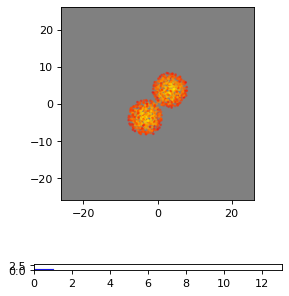

[[-3.5013739596311853, -3.509161895044098, 0], [3.5013739596311853, 3.509161895044098, 0]]
49
t= 0.25641025641025655


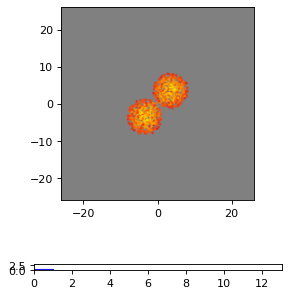

[[-3.6683935832776386, -3.327902744850485, 0], [3.6683935832776386, 3.327902744850485, 0]]
50
t= 0.26153846153846166


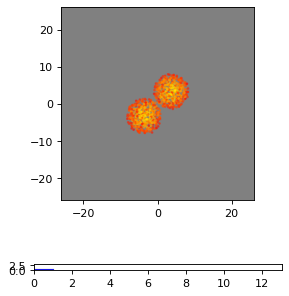

[[-3.826456988218052, -3.1381444844143562, 0], [3.826456988218052, 3.1381444844143562, 0]]
51
t= 0.2666666666666668


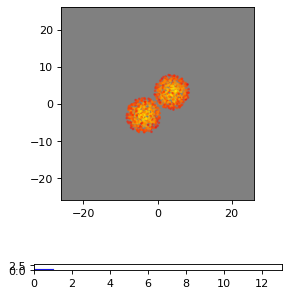

[[-3.9751790584941347, -2.9403922537768934, 0], [3.9751790584941347, 2.9403922537768934, 0]]
52
t= 0.2717948717948719


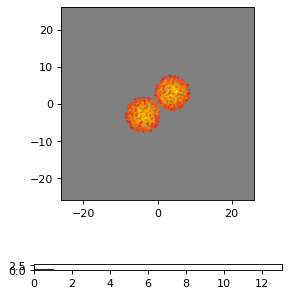

[[-4.114061842418685, -2.735199400196677, 0], [4.114061842418685, 2.735199400196677, 0]]
53
t= 0.276923076923077


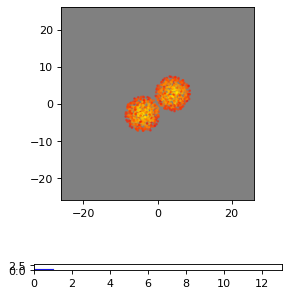

[[-4.242641741138057, -2.52312484071368, 0], [4.242641741138057, 2.52312484071368, 0]]
54
t= 0.2820512820512821


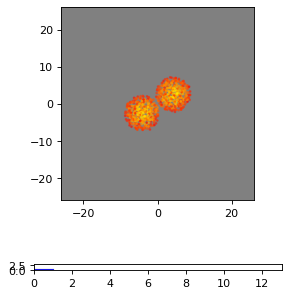

[[-4.360489508632151, -2.3047330621492828, 0], [4.360489508632151, 2.3047330621492828, 0]]
55
t= 0.2871794871794872


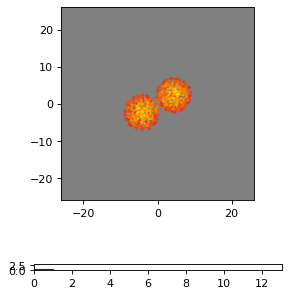

[[-4.467210251714428, -2.080594121106255, 0], [4.467210251714428, 2.080594121106255, 0]]
56
t= 0.2923076923076923


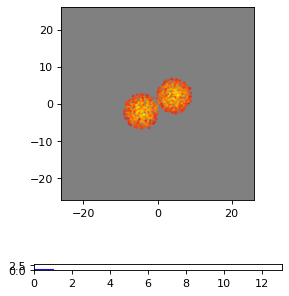

[[-4.5624434300319, -1.851283643968765, 0], [4.5624434300319, 1.851283643968765, 0]]
57
t= 0.29743589743589743


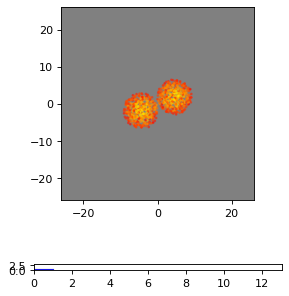

[[-4.645862856065134, -1.6173828269023816, 0], [4.645862856065134, 1.6173828269023816, 0]]
58
t= 0.30256410256410254


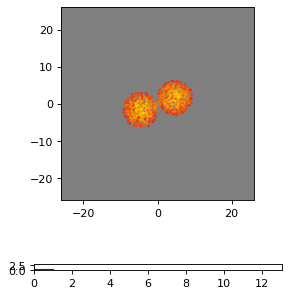

[[-4.7171766951282486, -1.3794784358540686, 0], [4.7171766951282486, 1.3794784358540686, 0]]
59
t= 0.30769230769230765


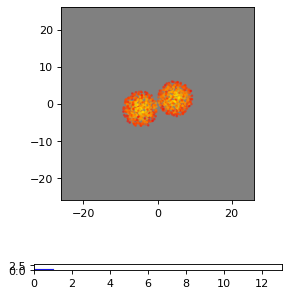

[[-4.776127465368918, -1.1381628065521878, 0], [4.776127465368918, 1.1381628065521878, 0]]
60
t= 0.31282051282051276


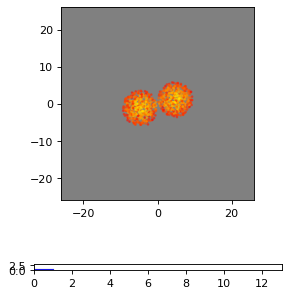

[[-4.822492037768368, -0.8940338445064983, 0], [4.822492037768368, 0.8940338445064983, 0]]
61
t= 0.3179487179487179


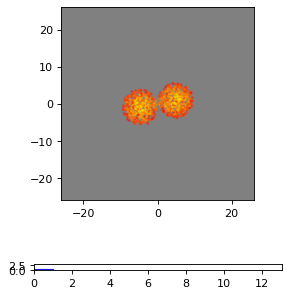

[[-4.856081636141379, -0.6476950250081603, 0], [4.856081636141379, 0.6476950250081603, 0]]
62
t= 0.323076923076923


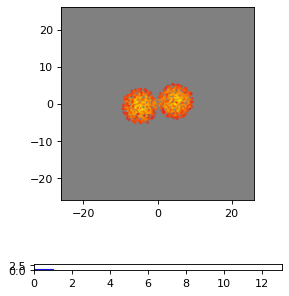

[[-4.8767418371362865, -0.3997553931297271, 0], [4.8767418371362865, 0.3997553931297271, 0]]
63
t= 0.3282051282051281


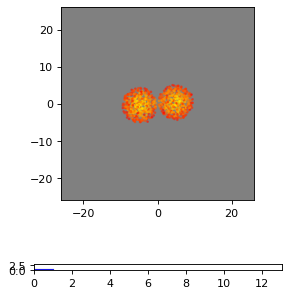

[[-4.8843525702349755, -0.15082956372515055, 0], [4.8843525702349755, 0.15082956372515055, 0]]
64
t= 0.3333333333333332


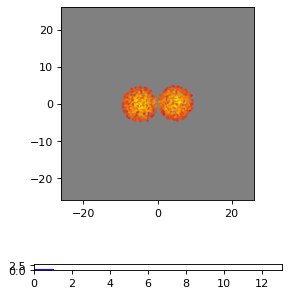

[[-4.87882811775289, 0.09846227857021883, 0], [4.87882811775289, -0.09846227857021883, 0]]
65
t= 0.3384615384615383


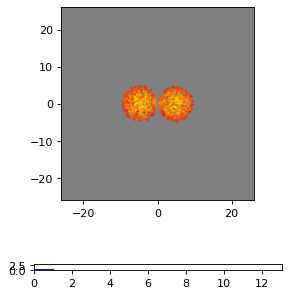

[[-4.8601171148390225, 0.347494379339634, 0], [4.8601171148390225, -0.347494379339634, 0]]
66
t= 0.3435897435897434


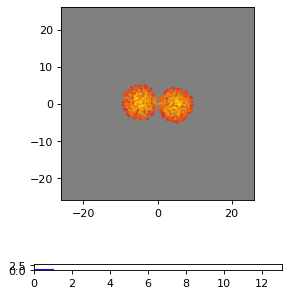

[[-4.828202549475922, 0.5956354143849502, 0], [4.828202549475922, -0.5956354143849502, 0]]
67
t= 0.34871794871794853


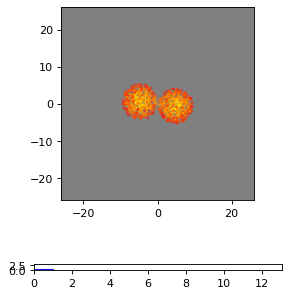

[[-4.783101762479691, 0.8422484897266247, 0], [4.783101762479691, -0.8422484897266247, 0]]
68
t= 0.35384615384615364


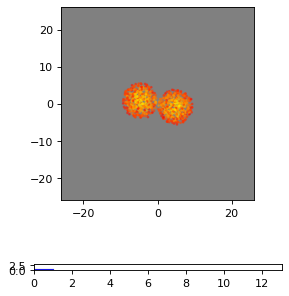

[[-4.724866447499986, 1.0866911416037155, 0], [4.724866447499986, -1.0866911416037155, 0]]
69
t= 0.35897435897435875


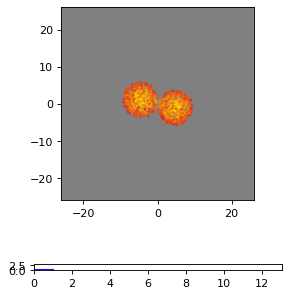

[[-4.65364637491088, 1.3284098706931802, 0], [4.65364637491088, -1.3284098706931802, 0]]
70
t= 0.36410256410256386


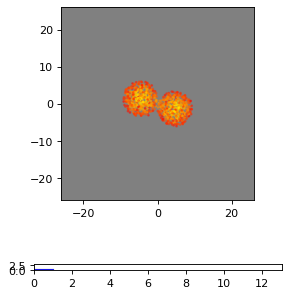

[[-4.569694726269992, 1.566838281692597, 0], [4.569694726269992, -1.566838281692597, 0]]
71
t= 0.369230769230769


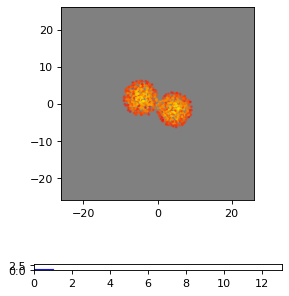

[[-4.473171610997161, 1.8011462165041374, 0], [4.473171610997161, -1.8011462165041374, 0]]
72
t= 0.3743589743589741


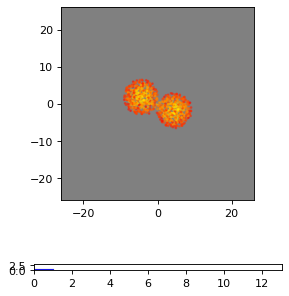

[[-4.364265462468307, 2.0305226231709437, 0], [4.364265462468307, -2.0305226231709437, 0]]
73
t= 0.3794871794871792


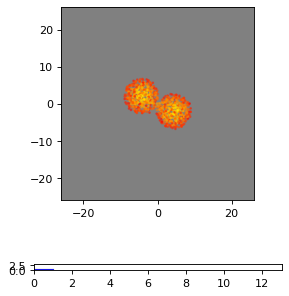

[[-4.243196979124061, 2.2541828693872965, 0], [4.243196979124061, -2.2541828693872965, 0]]
74
t= 0.3846153846153843


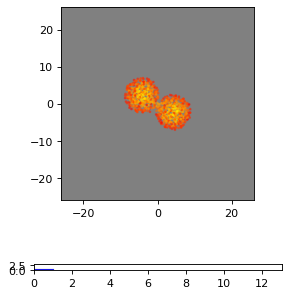

[[-4.1102191244697615, 2.471368742498616, 0], [4.1102191244697615, -2.471368742498616, 0]]
75
t= 0.3897435897435894


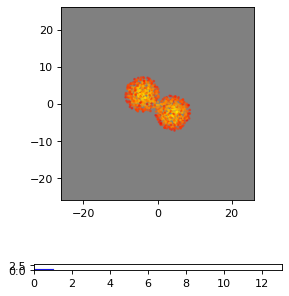

[[-3.965617127075456, 2.681348449501461, 0], [3.965617127075456, -2.681348449501461, 0]]
76
t= 0.3948717948717945


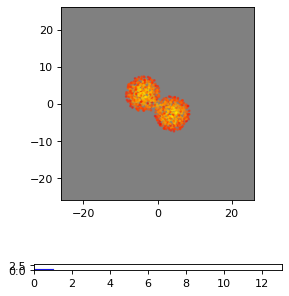

[[-3.8097084805758987, 2.8834166170435283, 0], [3.8097084805758987, -2.8834166170435283, 0]]
77
t= 0.39999999999999963


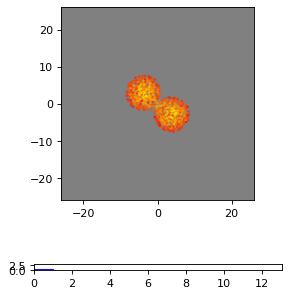

[[-3.6428429436705585, 3.0768942914236526, 0], [3.6428429436705585, -3.0768942914236526, 0]]
78
t= 0.40512820512820474


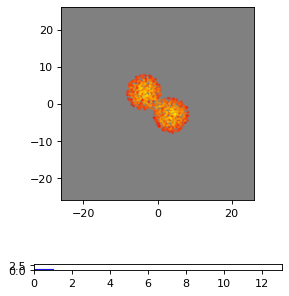

[[-3.4654025401236073, 3.26112893859181, 0], [3.4654025401236073, -3.26112893859181, 0]]
79
t= 0.41025641025640985


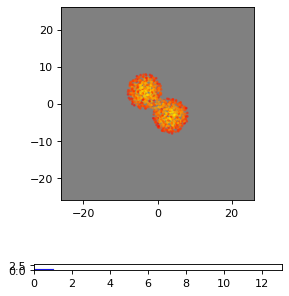

[[-3.277801558763927, 3.435494444149115, 0], [3.277801558763927, -3.435494444149115, 0]]
80
t= 0.41538461538461496


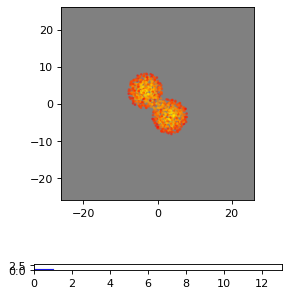

[[-3.08048655348511, 3.59939111334782, 0], [3.08048655348511, -3.59939111334782, 0]]
81
t= 0.4205128205128201


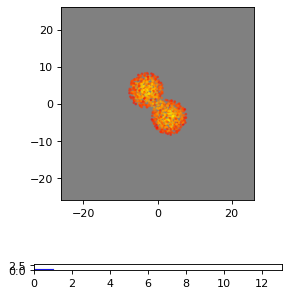

[[-2.8739363432454557, 3.7522456710913166, 0], [2.8739363432454557, -3.7522456710913166, 0]]
82
t= 0.4256410256410252


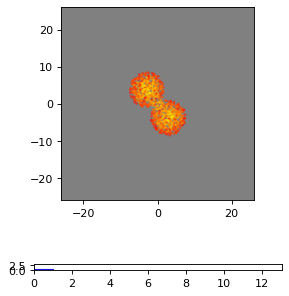

[[-2.658662012067974, 3.893511261934135, 0], [2.658662012067974, -3.893511261934135, 0]]
83
t= 0.4307692307692303


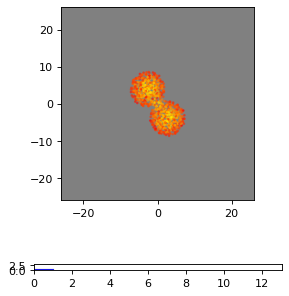

[[-2.435206909040379, 4.022667450081947, 0], [2.435206909040379, -4.022667450081947, 0]]
84
t= 0.4358974358974354


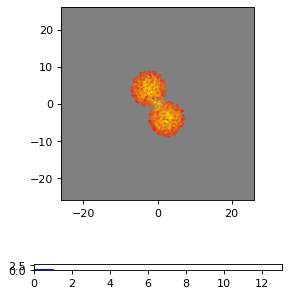

[[-2.204146648315106, 4.1392202193915555, 0], [2.204146648315106, -4.1392202193915555, 0]]
85
t= 0.4410256410256405


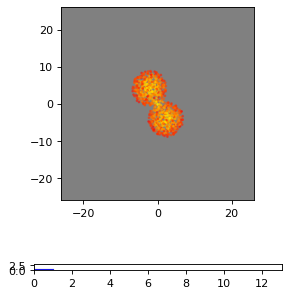

[[-1.9660891091092787, 4.242701973370913, 0], [1.9660891091092787, -4.242701973370913, 0]]
86
t= 0.4461538461538456


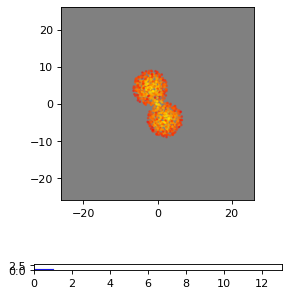

[[-1.721674435704752, 4.332671535179101, 0], [1.721674435704752, -4.332671535179101, 0]]
87
t= 0.45128205128205073


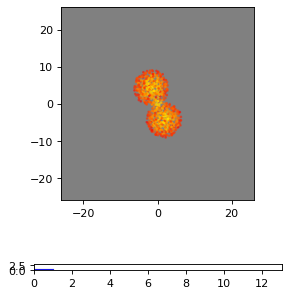

[[-1.4715727644515788, 4.408721601086604, 0], [1.4715727644515788, -4.408721601086604, 0]]
88
t= 0.45641025641025584


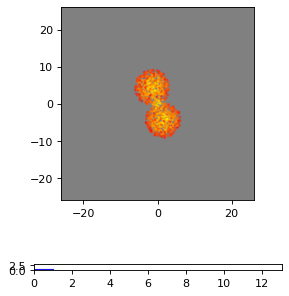

[[-1.2164545947406964, 4.470699621616141, 0], [1.2164545947406964, -4.470699621616141, 0]]
89
t= 0.46153846153846095


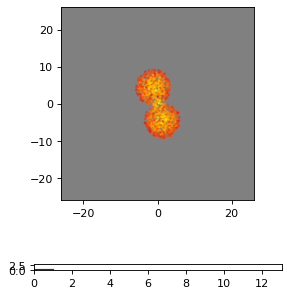

[[-0.9571845995593297, 4.518269484294607, 0], [0.9571845995593297, -4.518269484294607, 0]]
90
t= 0.46666666666666606


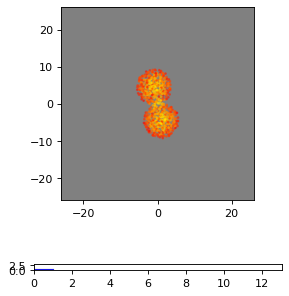

[[-0.6946975155131841, 4.551003346832242, 0], [0.6946975155131841, -4.551003346832242, 0]]
91
t= 0.4717948717948712


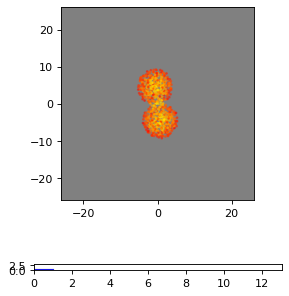

[[-0.4299338596340488, 4.568532334435092, 0], [0.4299338596340488, -4.568532334435092, 0]]
92
t= 0.4769230769230763


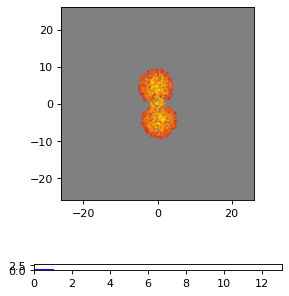

[[-0.16383992937975878, 4.570546539805017, 0], [0.16383992937975878, -4.570546539805017, 0]]
93
t= 0.4820512820512814


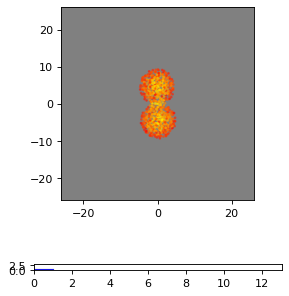

[[0.10263219736576817, 4.556795023139685, 0], [-0.10263219736576817, -4.556795023139685, 0]]
94
t= 0.4871794871794865


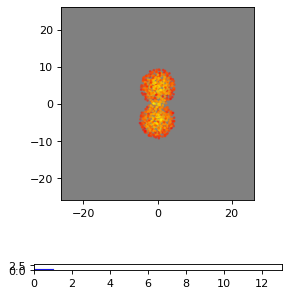

[[0.36852466229256614, 4.527085812132578, 0], [-0.36852466229256614, -4.527085812132578, 0]]
95
t= 0.4923076923076916


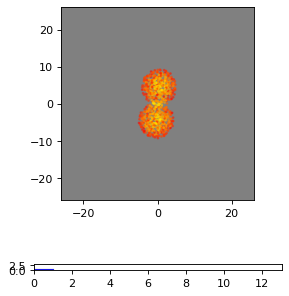

[[0.6328738266645872, 4.481285901972984, 0], [-0.6328738266645872, -4.481285901972984, 0]]
96
t= 0.4974358974358967


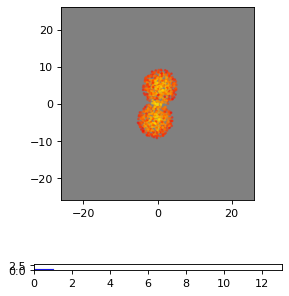

[[0.8947102713197388, 4.419321255346004, 0], [-0.8947102713197388, -4.419321255346004, 0]]
97
t= 0.5025641025641019


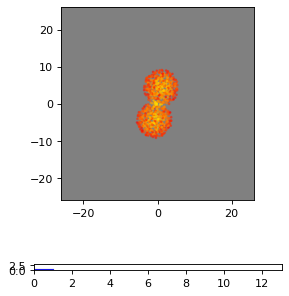

[[1.1530587966698453, 4.34117680243255, 0], [-1.1530587966698453, -4.34117680243255, 0]]
98
t= 0.507692307692307


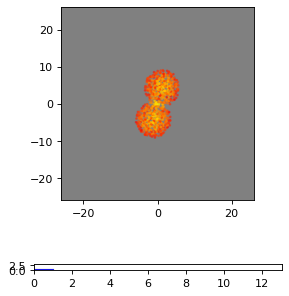

[[1.4069384227006698, 4.246896440909343, 0], [-1.4069384227006698, -4.246896440909343, 0]]
99
t= 0.5128205128205121


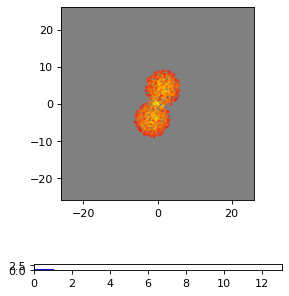

[[1.6553623889719238, 4.136583035948915, 0], [-1.6553623889719238, -4.136583035948915, 0]]
100
t= 0.5179487179487172


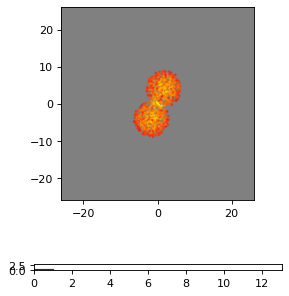

[[1.8973381546172363, 4.010398420219611, 0], [-1.8973381546172363, -4.010398420219611, 0]]
101
t= 0.5230769230769223


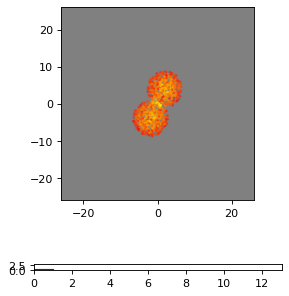

[[2.131867398344185, 3.868563393885578, 0], [-2.131867398344185, -3.868563393885578, 0]]
102
t= 0.5282051282051274


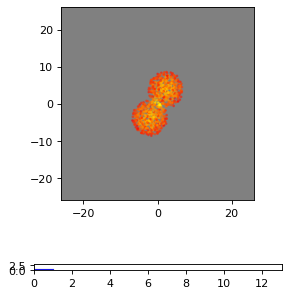

[[2.3579460184342733, 3.711357724606787, 0], [-2.3579460184342733, -3.711357724606787, 0]]
103
t= 0.5333333333333325


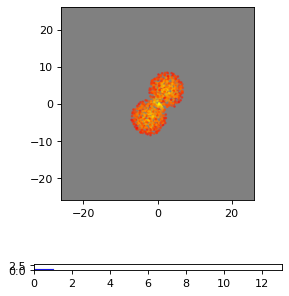

[[2.5745641327429505, 3.539120147539005, 0], [-2.5745641327429505, -3.539120147539005, 0]]
104
t= 0.5384615384615377


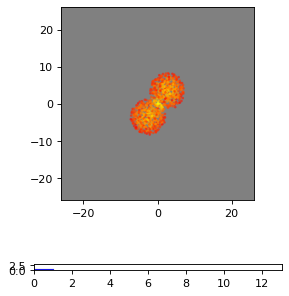

[[2.7809530316893256, 3.3522123174394447, 0], [-2.7809530316893256, -3.3522123174394447, 0]]
105
t= 0.5435897435897428


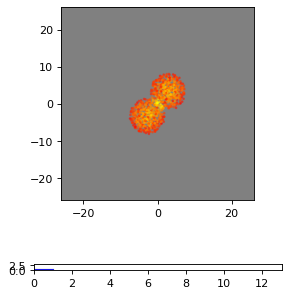

[[2.976132569685383, 3.1511560590131067, 0], [-2.976132569685383, -3.1511560590131067, 0]]
106
t= 0.5487179487179479


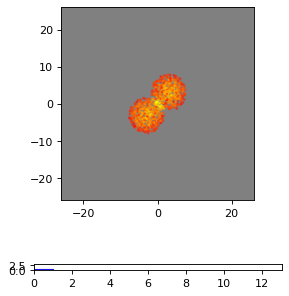

[[3.1588023215970678, 2.936631519405737, 0], [-3.1588023215970678, -2.936631519405737, 0]]
107
t= 0.553846153846153


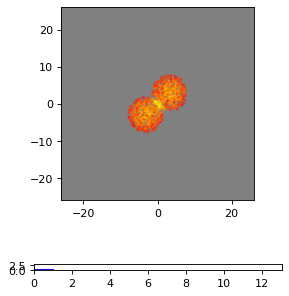

[[3.3277249484815483, 2.7093904383919454, 0], [-3.3277249484815483, -2.7093904383919454, 0]]
108
t= 0.5589743589743581


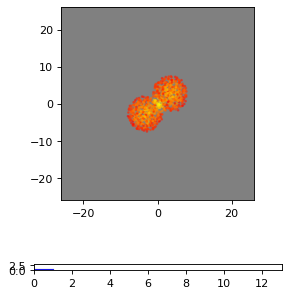

[[3.4817262219034646, 2.4702561435705834, 0], [-3.4817262219034646, -2.4702561435705834, 0]]
109
t= 0.5641025641025632


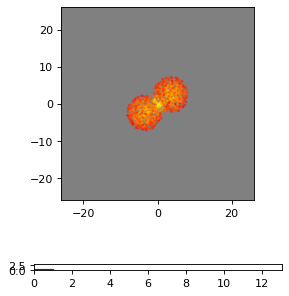

[[3.619695023934902, 2.2201235503647663, 0], [-3.619695023934902, -2.2201235503647663, 0]]
110
t= 0.5692307692307683


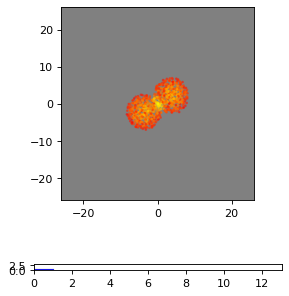

[[3.7405833471554226, 1.959959162021844, 0], [-3.7405833471554226, -1.959959162021844, 0]]
111
t= 0.5743589743589734


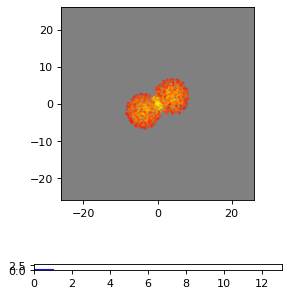

[[3.843406294652037, 1.6908010696134335, 0], [-3.843406294652037, -1.6908010696134335, 0]]
112
t= 0.5794871794871785


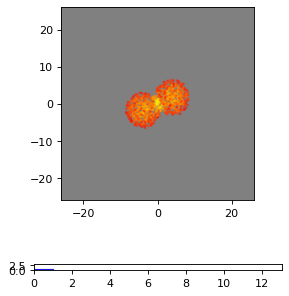

[[3.9272420800192256, 1.4137589520353835, 0], [-3.9272420800192256, -1.4137589520353835, 0]]
113
t= 0.5846153846153836


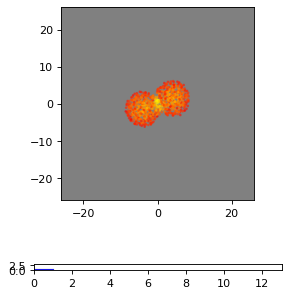

[[3.991232027358924, 1.1300140760078081, 0], [-3.991232027358924, -1.1300140760078081, 0]]
114
t= 0.5897435897435888


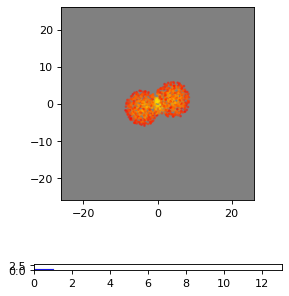

[[4.034580571280531, 0.8408192960750716, 0], [-4.034580571280531, -0.8408192960750716, 0]]
115
t= 0.5948717948717939


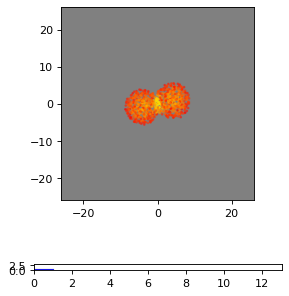

[[4.05655525690091, 0.5474990546057718, 0], [-4.05655525690091, -0.5474990546057718, 0]]
116
t= 0.599999999999999


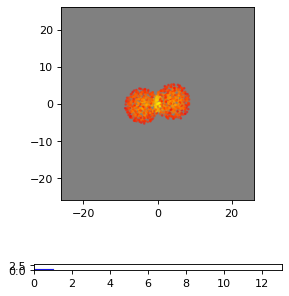

[[4.056486739844379, 0.25144938179277987, 0], [-4.056486739844379, -0.25144938179277987, 0]]
117
t= 0.6051282051282041


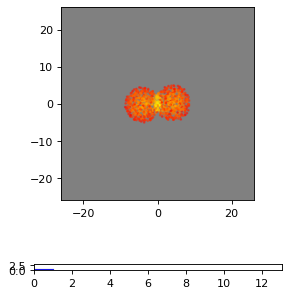

[[4.033768786242723, -0.04586210434680493, 0], [-4.033768786242723, 0.04586210434680493, 0]]
118
t= 0.6102564102564092


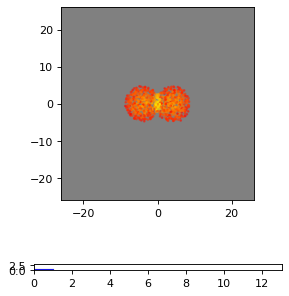

[[3.987858272735184, -0.34289619797161275, 0], [-3.987858272735184, 0.34289619797161275, 0]]
119
t= 0.6153846153846143


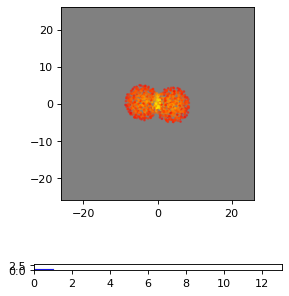

[[3.9183572471168633, -0.6381089629628491, 0], [-3.9183572471168633, 0.6381089629628491, 0]]
120
t= 0.6205128205128194


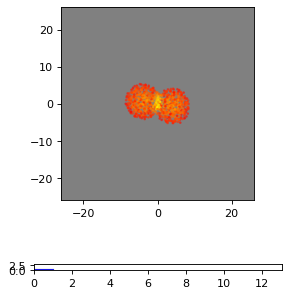

[[3.825229729443411, -0.9299249623940504, 0], [-3.825229729443411, 0.9299249623940504, 0]]
121
t= 0.6256410256410245


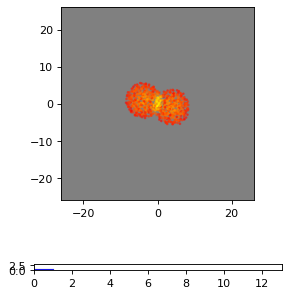

[[3.7081813889820143, -1.2161013172575323, 0], [-3.7081813889820143, 1.2161013172575323, 0]]
122
t= 0.6307692307692296


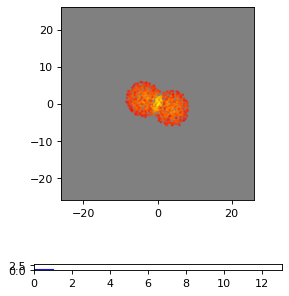

[[3.567071103657153, -1.494300169642917, 0], [-3.567071103657153, 1.494300169642917, 0]]
123
t= 0.6358974358974347


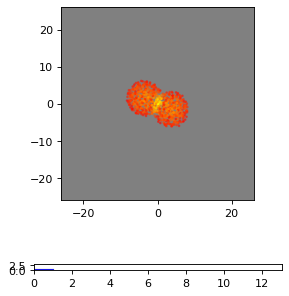

[[3.401973924248499, -1.7621562825103618, 0], [-3.401973924248499, 1.7621562825103618, 0]]
124
t= 0.6410256410256399


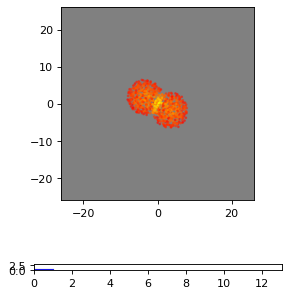

[[3.213181074390894, -2.0172770396906006, 0], [-3.213181074390894, 2.0172770396906006, 0]]
125
t= 0.646153846153845


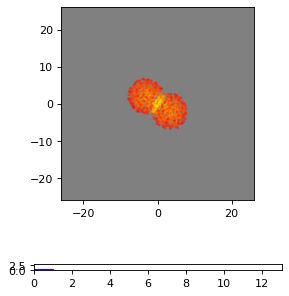

[[3.0011999505743714, -2.2572424458849034, 0], [-3.0011999505743714, 2.2572424458849034, 0]]
126
t= 0.6512820512820501


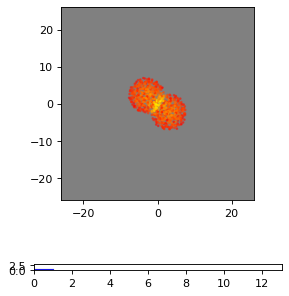

[[2.766754122144133, -2.479605126665117, 0], [-2.766754122144133, 2.479605126665117, 0]]
127
t= 0.6564102564102552


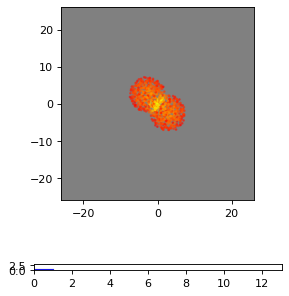

[[2.5107833313005767, -2.681890328473624, 0], [-2.5107833313005767, 2.681890328473624, 0]]
128
t= 0.6615384615384603


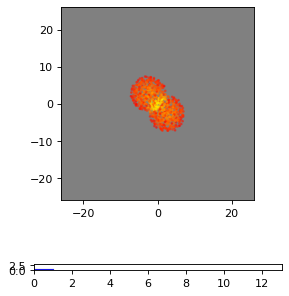

[[2.234443493099261, -2.8615959186233795, 0], [-2.234443493099261, 2.8615959186233795, 0]]
129
t= 0.6666666666666654


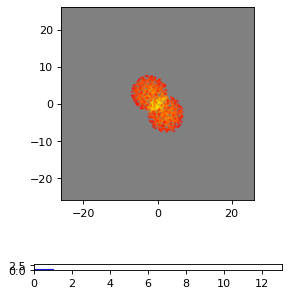

[[1.939106695450943, -3.0161923852978862, 0], [-1.939106695450943, 3.0161923852978862, 0]]
130
t= 0.6717948717948705


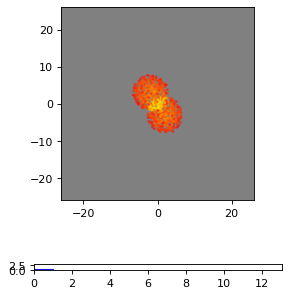

[[1.6263611991215587, -3.143122837551202, 0], [-1.6263611991215587, 3.143122837551202, 0]]
131
t= 0.6769230769230756


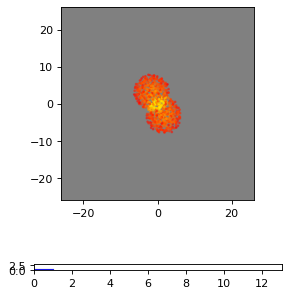

[[1.2980136984913386, -3.2398061240521008, 0], [-1.2980136984913386, 3.2398061240521008, 0]]
132
t= 0.6820512820512807


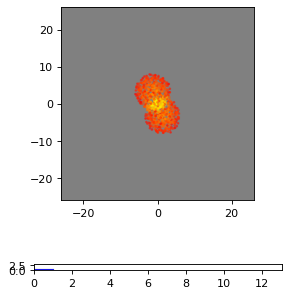

[[0.9564450352961444, -3.303868758553275, 0], [-0.9564450352961444, 3.303868758553275, 0]]
133
t= 0.6871794871794858


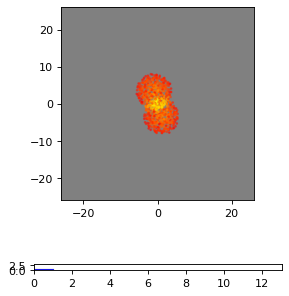

[[0.6046430061989927, -3.3325548875314843, 0], [-0.6046430061989927, 3.3325548875314843, 0]]
134
t= 0.692307692307691


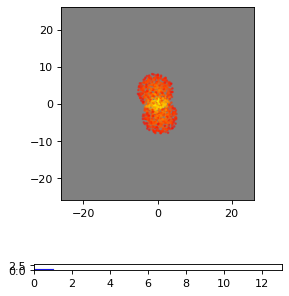

[[0.24604059275155132, -3.3231079520456177, 0], [-0.24604059275155132, 3.3231079520456177, 0]]
135
t= 0.6974358974358961


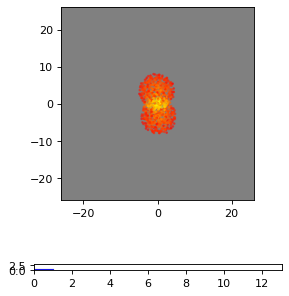

[[-0.11535431411831665, -3.273112906124574, 0], [0.11535431411831665, 3.273112906124574, 0]]
136
t= 0.7025641025641012


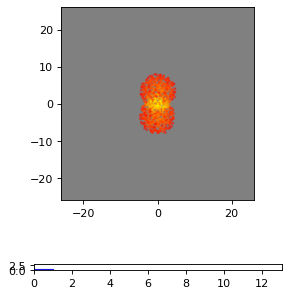

[[-0.47495891410650304, -3.1804962167672626, 0], [0.47495891410650304, 3.1804962167672626, 0]]
137
t= 0.7076923076923063


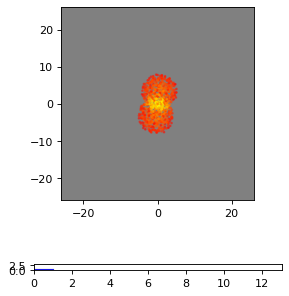

[[-0.8276154975327046, -3.0435258639425946, 0], [0.8276154975327046, 3.0435258639425946, 0]]
138
t= 0.7128205128205114


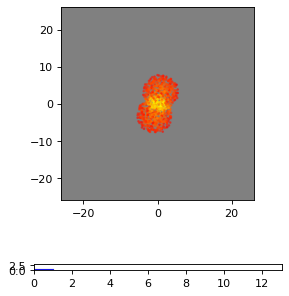

[[-1.1675914453403773, -2.860811340589495, 0], [1.1675914453403773, 2.860811340589495, 0]]
139
t= 0.7179487179487165


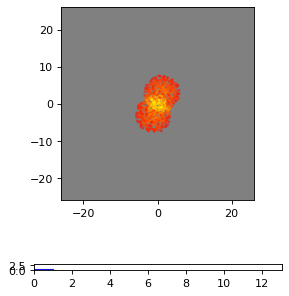

[[-1.48844408741763, -2.631387489757848, 0], [1.48844408741763, 2.631387489757848, 0]]
140
t= 0.7230769230769216


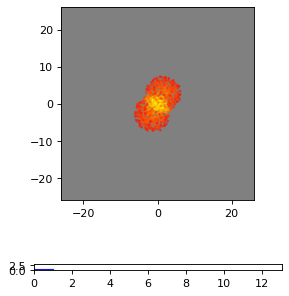

[[-1.782376678811093, -2.354726384221829, 0], [1.782376678811093, 2.354726384221829, 0]]
141
t= 0.7282051282051267


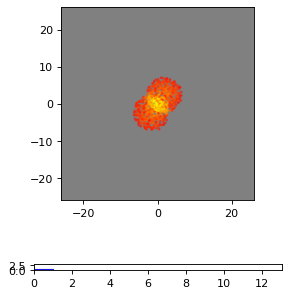

[[-2.0408106304027633, -2.0313017313005775, 0], [2.0408106304027633, 2.0313017313005775, 0]]
142
t= 0.7333333333333318


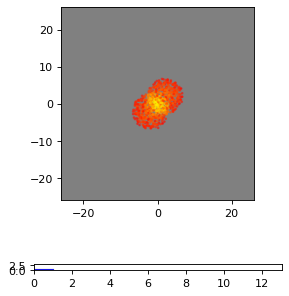

[[-2.254361682663218, -1.663755527930959, 0], [2.254361682663218, 1.663755527930959, 0]]
143
t= 0.738461538461537


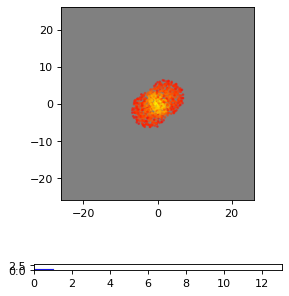

[[-2.412813173644949, -1.2569533165391744, 0], [2.412813173644949, 1.2569533165391744, 0]]
144
t= 0.7435897435897421


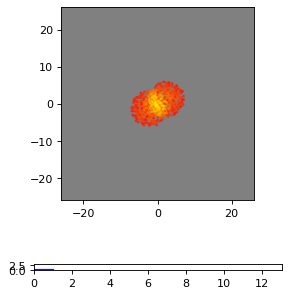

[[-2.505116038982393, -0.8179841850407057, 0], [2.505116038982393, 0.8179841850407057, 0]]
145
t= 0.7487179487179472


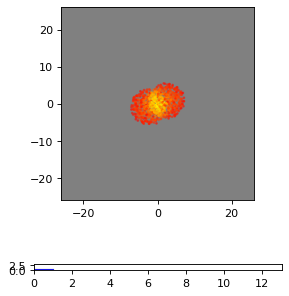

[[-2.5193888118919086, -0.35616076684036907, 0], [2.5193888118919086, 0.35616076684036907, 0]]
146
t= 0.7538461538461523


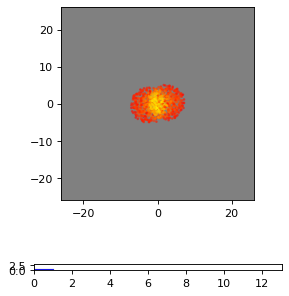

[[-2.4429445233168643, 0.11695091895102039, 0], [2.4429445233168643, -0.11695091895102039, 0]]
147
t= 0.7589743589743574


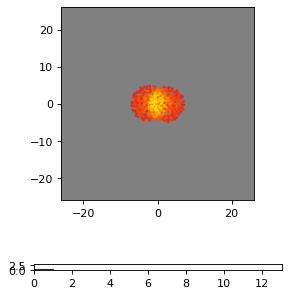

[[-2.263940793591165, 0.5848018704369016, 0], [2.263940793591165, -0.5848018704369016, 0]]
148
t= 0.7641025641025625


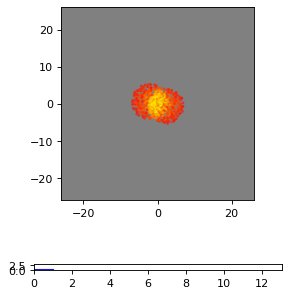

[[-1.9719312174489854, 1.022609689520457, 0], [1.9719312174489854, -1.022609689520457, 0]]
149
t= 0.7692307692307676


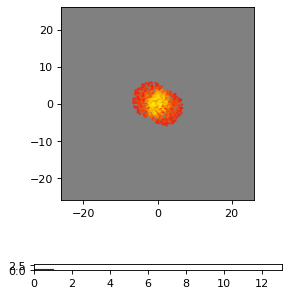

[[-1.5593511288087047, 1.3965111506720762, 0], [1.5593511288087047, -1.3965111506720762, 0]]
150
t= 0.7743589743589727


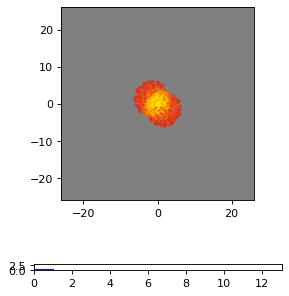

[[-1.026625711676056, 1.6602571764227658, 0], [1.026625711676056, -1.6602571764227658, 0]]
151
t= 0.7794871794871778


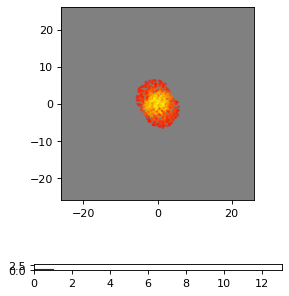

[[-0.3909984175663146, 1.751178302654735, 0], [0.3909984175663146, -1.751178302654735, 0]]
152
t= 0.7846153846153829


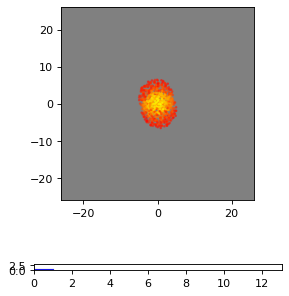

[[0.2951444993696541, 1.5882977259369677, 0], [-0.2951444993696541, -1.5882977259369677, 0]]
153
t= 0.789743589743588


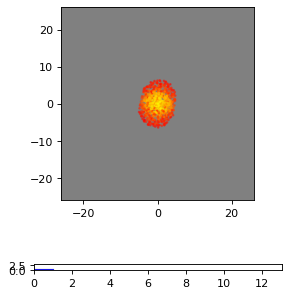

[[0.9032286953649394, 1.07867360919783, 0], [-0.9032286953649394, -1.07867360919783, 0]]
154
t= 0.7948717948717932


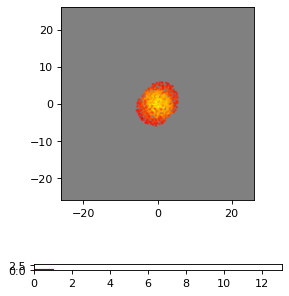

[[1.1390341156432653, 0.1815599263647943, 0], [-1.1390341156432653, -0.1815599263647943, 0]]
155
t= 0.7999999999999983


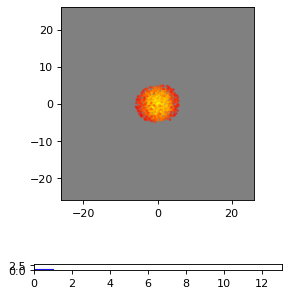

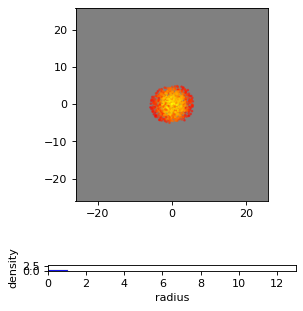

R =  13 , M= 1 , k= 10


0

In [234]:
com_list = get_com_lists(R = 10)
combined_star.plot_init=True
params={"k":10,"n":1,"nu":1}
combined_star.update_star_new(tag=kt,plotRealTime=True,dt = 0.5,COM_POSITIONS=com_list,params=params)

In [149]:
starting_coordinate = [1,0,0]
starting_velocity = [0,1,0]

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

v = starting_coordinate[:-1] + starting_velocity[:-1]
print(v)

[1, 0, 0, 1]


t= 4.99999999999999


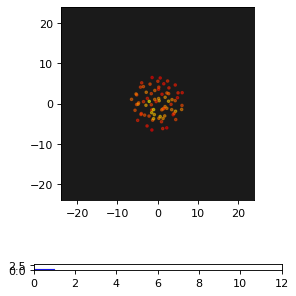

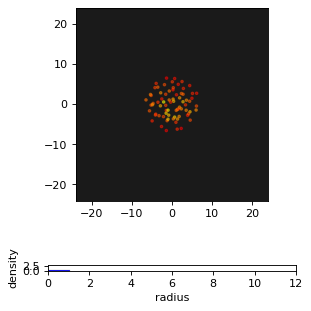

R =  12 , M= 2 , k= 100


0

In [22]:
# "cubic_spline"
main(npts=75,R=12,tag="cubic_spline")

t= 4.99999999999999


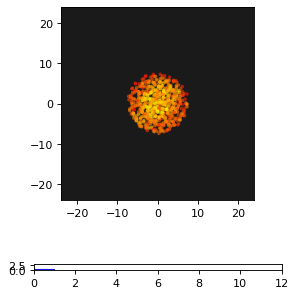

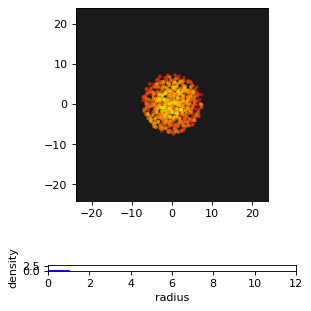

R =  12 , M= 2 , k= 100


0

In [23]:
# "wendland_2"
main(npts=600,R=12,tag="cubic_spline")

t= 4.99999999999999


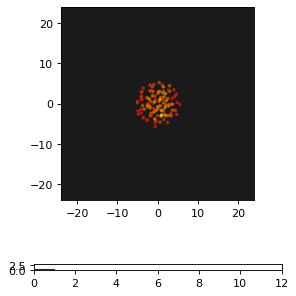

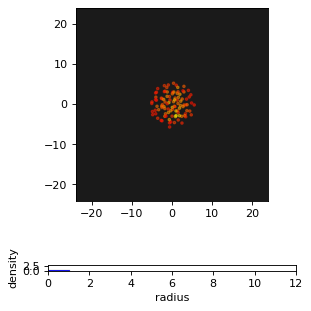

R =  12 , M= 2 , k= 100


0

In [24]:
# gaussian kernel (me)
main(npts=100,R=12)

t= 4.99999999999999


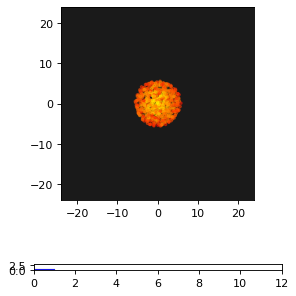

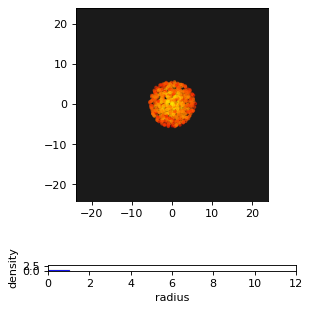

R =  12 , M= 2 , k= 100


0

In [25]:
# gaussian kernel (medium)
main(npts=600,R=12)